In [109]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

In [110]:
# import gpu dataset
df = pd.read_csv('./PC_Part_Picker_Datasets/GPU_Data_Cleaned.csv')
df

,Name,Chipset,Memory,Core Clock,Boost Clock,Length,Rating,Rating Count,Price,Component
0,MSI GeForce RTX 3060 Ventus 2X 12G,GeForce RTX 3060 12GB,12.0,1320 MHz,1777 MHz,235 mm,5,26,309.99,GPU
1,Gigabyte WINDFORCE OC,GeForce RTX 4070,12.0,1920 MHz,2490 MHz,261 mm,5,18,549.99,GPU
2,Asus DUAL OC,GeForce RTX 4060,8.0,1830 MHz,2535 MHz,227 mm,5,4,304.99,GPU
3,Asus ROG STRIX GAMING OC,GeForce RTX 4090,24.0,2235 MHz,2640 MHz,358 mm,5,8,2423.90,GPU
4,PNY VCNRTX6000ADA-PB,RTX 6000 Ada Generation,48.0,915 MHz,2505 MHz,267 mm,0,0,9999.00,GPU
...,...,...,...,...,...,...,...,...,...,...
1056,ATI FirePro S7000,FirePro S7000,4.0,950 MHz,NaN,292 mm,0,0,299.99,GPU
1057,HP C2J94AT,Quadro K4000,3.0,810 MHz,NaN,241 mm,0,0,199.99,GPU
1058,ATI 100-505553,FirePro V5700,0.5,NaN,NaN,NaN,0,0,129.99,GPU
1059,ATI FirePro RG220A,FirePro RG220A,0.5,800 MHz,NaN,168 mm,0,0,120.00,GPU


In [111]:
# define chipset strings that relate to GPU chipset maanufacturers
nvidia_chipset_terms = ['geforce', 'gforce', 'quadro', 'rtx', 'nvs', 'titan', r'T[0-9][0-9][0-9]+']
amd_chipset_terms    = ['radeon' , 'firepro']
intel_chipset_terms  = ['arc']

# create a new column for chipset manufacturer
df['Chipset_Manufacturer'] = 'unknown'

# using regular expression, loop over each column and assign the chipset manufacturer
temp = []
for index, row in df.iterrows():
    chipset = row['Chipset']
    chipset = chipset.lower()
    if any(re.search(term, chipset, re.IGNORECASE) for term in nvidia_chipset_terms):
        df.at[index, 'Chipset_Manufacturer'] = 'nvidia'
        temp.append(f'nvidia: {chipset}')
    elif any(re.search(term, chipset) for term in amd_chipset_terms):
        df.at[index, 'Chipset_Manufacturer'] = 'amd'
        temp.append(f'amd   : {chipset}')
    elif any(re.search(term, chipset) for term in intel_chipset_terms):
        df.at[index, 'Chipset_Manufacturer'] = 'intel'
        temp.append(f'intel : {chipset}')

# print any with chipset that contains unknown
df[df['Chipset_Manufacturer'] == 'unknown']

,Name,Chipset,Memory,Core Clock,Boost Clock,Length,Rating,Rating Count,Price,Component,Chipset_Manufacturer


In [112]:
# print the updated dataframe
df

,Name,Chipset,Memory,Core Clock,Boost Clock,Length,Rating,Rating Count,Price,Component,Chipset_Manufacturer
0,MSI GeForce RTX 3060 Ventus 2X 12G,GeForce RTX 3060 12GB,12.0,1320 MHz,1777 MHz,235 mm,5,26,309.99,GPU,nvidia
1,Gigabyte WINDFORCE OC,GeForce RTX 4070,12.0,1920 MHz,2490 MHz,261 mm,5,18,549.99,GPU,nvidia
2,Asus DUAL OC,GeForce RTX 4060,8.0,1830 MHz,2535 MHz,227 mm,5,4,304.99,GPU,nvidia
3,Asus ROG STRIX GAMING OC,GeForce RTX 4090,24.0,2235 MHz,2640 MHz,358 mm,5,8,2423.90,GPU,nvidia
4,PNY VCNRTX6000ADA-PB,RTX 6000 Ada Generation,48.0,915 MHz,2505 MHz,267 mm,0,0,9999.00,GPU,nvidia
...,...,...,...,...,...,...,...,...,...,...,...
1056,ATI FirePro S7000,FirePro S7000,4.0,950 MHz,NaN,292 mm,0,0,299.99,GPU,amd
1057,HP C2J94AT,Quadro K4000,3.0,810 MHz,NaN,241 mm,0,0,199.99,GPU,nvidia
1058,ATI 100-505553,FirePro V5700,0.5,NaN,NaN,NaN,0,0,129.99,GPU,amd
1059,ATI FirePro RG220A,FirePro RG220A,0.5,800 MHz,NaN,168 mm,0,0,120.00,GPU,amd


In [113]:
# let's define which columns we plan to use as features for clustering
feature_cols = ['Memory', 'Core Clock', 'Boost Clock', 'Length', 'Price']

# we don't care about other columns, so we can drop them
df = df.drop(columns=[col for col in df.columns if col not in feature_cols + ['Chipset_Manufacturer']])
df

,Memory,Core Clock,Boost Clock,Length,Price,Chipset_Manufacturer
0,12.0,1320 MHz,1777 MHz,235 mm,309.99,nvidia
1,12.0,1920 MHz,2490 MHz,261 mm,549.99,nvidia
2,8.0,1830 MHz,2535 MHz,227 mm,304.99,nvidia
3,24.0,2235 MHz,2640 MHz,358 mm,2423.90,nvidia
4,48.0,915 MHz,2505 MHz,267 mm,9999.00,nvidia
...,...,...,...,...,...,...
1056,4.0,950 MHz,NaN,292 mm,299.99,amd
1057,3.0,810 MHz,NaN,241 mm,199.99,nvidia
1058,0.5,NaN,NaN,NaN,129.99,amd
1059,0.5,800 MHz,NaN,168 mm,120.00,amd


In [114]:
# next we need to convert the core clock and boost clock to numerical values, but first we need to check what possible units are used

# print all unique values of suffixes for the core clock
print(df['Core Clock'].str.extract(r'([a-zA-Z]+)', expand=False).unique())

# and same for boost closk
print(df['Boost Clock'].str.extract(r'([a-zA-Z]+)', expand=False).unique())

# we can see that units are always MHz, so we can simply remove any non-numeric characters and convert to float
df['Core Clock' ] = df['Core Clock' ].str.extract(r'([0-9]+)', expand=False).astype(float)
df['Boost Clock'] = df['Boost Clock'].str.extract(r'([0-9]+)', expand=False).astype(float)
print(df.info())
df

['MHz' nan]
['MHz' nan]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Memory                1061 non-null   float64
 1   Core Clock            1044 non-null   float64
 2   Boost Clock           889 non-null    float64
 3   Length                1040 non-null   object 
 4   Price                 1061 non-null   float64
 5   Chipset_Manufacturer  1061 non-null   object 
dtypes: float64(4), object(2)
memory usage: 49.9+ KB
None


,Memory,Core Clock,Boost Clock,Length,Price,Chipset_Manufacturer
0,12.0,1320.0,1777.0,235 mm,309.99,nvidia
1,12.0,1920.0,2490.0,261 mm,549.99,nvidia
2,8.0,1830.0,2535.0,227 mm,304.99,nvidia
3,24.0,2235.0,2640.0,358 mm,2423.90,nvidia
4,48.0,915.0,2505.0,267 mm,9999.00,nvidia
...,...,...,...,...,...,...
1056,4.0,950.0,NaN,292 mm,299.99,amd
1057,3.0,810.0,NaN,241 mm,199.99,nvidia
1058,0.5,NaN,NaN,NaN,129.99,amd
1059,0.5,800.0,NaN,168 mm,120.00,amd


In [115]:
# let's repeat this process for length
print(df['Length'].str.extract(r'([a-zA-Z]+)', expand=False).unique())

# we can see that units are always mm, so we can simply remove any non-numeric characters and convert to float
df['Length'] = df['Length'].str.extract(r'([0-9]+)', expand=False).astype(float)
print(df.info())
df

['mm' nan]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Memory                1061 non-null   float64
 1   Core Clock            1044 non-null   float64
 2   Boost Clock           889 non-null    float64
 3   Length                1040 non-null   float64
 4   Price                 1061 non-null   float64
 5   Chipset_Manufacturer  1061 non-null   object 
dtypes: float64(5), object(1)
memory usage: 49.9+ KB
None


,Memory,Core Clock,Boost Clock,Length,Price,Chipset_Manufacturer
0,12.0,1320.0,1777.0,235.0,309.99,nvidia
1,12.0,1920.0,2490.0,261.0,549.99,nvidia
2,8.0,1830.0,2535.0,227.0,304.99,nvidia
3,24.0,2235.0,2640.0,358.0,2423.90,nvidia
4,48.0,915.0,2505.0,267.0,9999.00,nvidia
...,...,...,...,...,...,...
1056,4.0,950.0,NaN,292.0,299.99,amd
1057,3.0,810.0,NaN,241.0,199.99,nvidia
1058,0.5,NaN,NaN,NaN,129.99,amd
1059,0.5,800.0,NaN,168.0,120.00,amd


In [116]:
# Let's switch focus now to handling NaN values, first let's print the counts for each feature
print(df.isna().sum())

Memory                    0
Core Clock               17
Boost Clock             172
Length                   21
Price                     0
Chipset_Manufacturer      0
dtype: int64


C:\Users\knopp\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


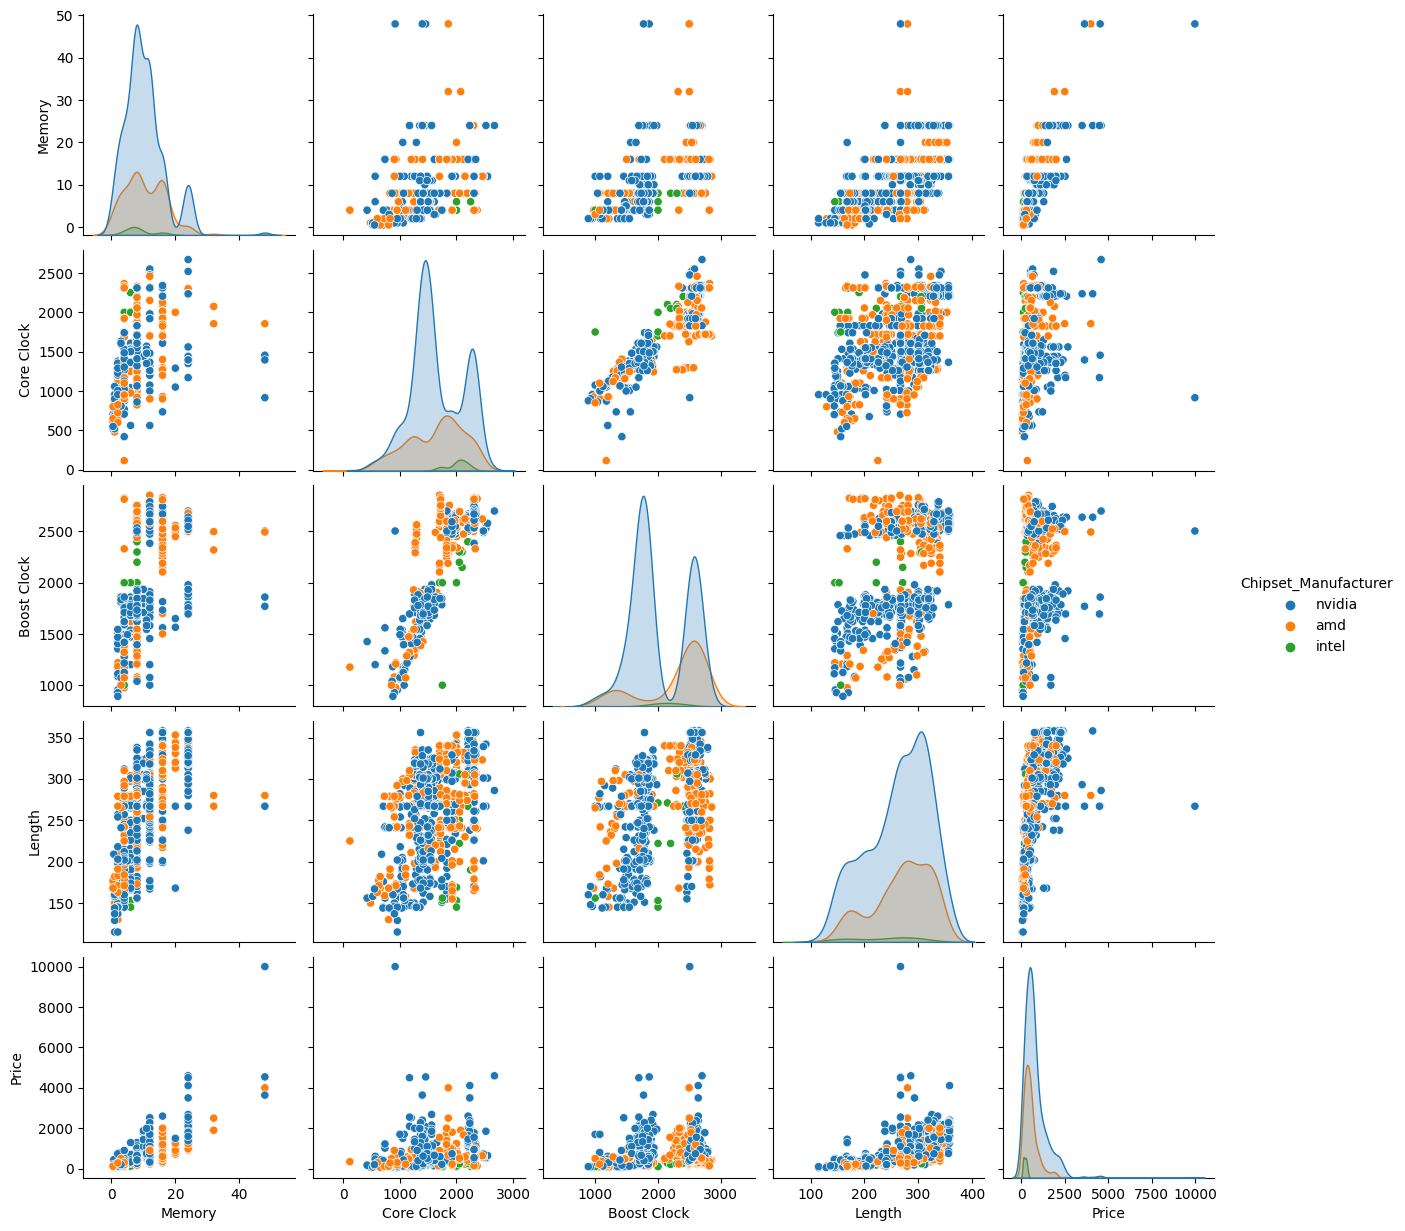

In [117]:
# let's create a pair plot to see how each feature relates to the other (might help with filling in NaN values)
sns.pairplot(df, hue='Chipset_Manufacturer')

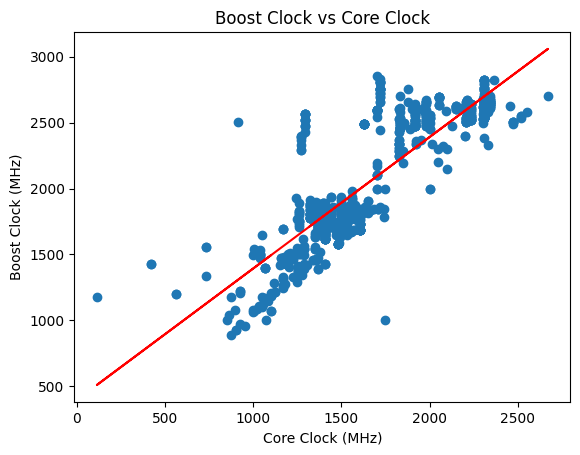

In [118]:
# There seems to be a strong correlation between core clock and boost clock, let's use linear regression to predict the missing boost clock values
X = df.dropna(subset=['Boost Clock', 'Core Clock'])[['Core Clock']]
y = df.dropna(subset=['Boost Clock', 'Core Clock'])['Boost Clock']
boost_clock_model = LinearRegression().fit(X, y)

# let's see how this trendline fits the data
plt.scatter(X, y)
plt.plot(X, boost_clock_model.predict(X), color='red')
plt.xlabel('Core Clock (MHz)')
plt.ylabel('Boost Clock (MHz)')
plt.title('Boost Clock vs Core Clock')
plt.show()

In [119]:
# Now let's fill in as many missing boost clock values as we can
df.loc[df['Boost Clock'].isna() & df['Core Clock'].notna(), 'Boost Clock'] = boost_clock_model.predict(df.loc[df['Boost Clock'].isna() & df['Core Clock'].notna()][['Core Clock']])

# print the updated nan counts
print(df.isna().sum())

Memory                   0
Core Clock              17
Boost Clock             17
Length                  21
Price                    0
Chipset_Manufacturer     0
dtype: int64


In [120]:
# Let's check if the remaining nans for clock speeds are for the same rows
print(df[df['Core Clock'].isna() | df['Boost Clock'].isna()])

      Memory  Core Clock  Boost Clock  Length   Price Chipset_Manufacturer
830      2.0         NaN          NaN     NaN   66.34                  amd
955      1.0         NaN          NaN   170.0  136.99                  amd
976      2.0         NaN          NaN     NaN  218.86                  amd
977      2.0         NaN          NaN     NaN  139.71               nvidia
981      0.5         NaN          NaN     NaN   99.00                  amd
990      0.5         NaN          NaN     NaN   96.96                  amd
1005     0.5         NaN          NaN     NaN   99.99               nvidia
1006     2.0         NaN          NaN   198.0  111.00               nvidia
1009     6.0         NaN          NaN     NaN  329.99               nvidia
1022     2.5         NaN          NaN     NaN  196.99               nvidia
1028     0.5         NaN          NaN     NaN  108.99               nvidia
1034     2.0         NaN          NaN     NaN   99.99               nvidia
1037     2.0         NaN 

In [121]:
# Since they are, let's use the next best correlation for core clock of memory
X = df.dropna(subset=['Memory', 'Core Clock'])[['Memory']]
y = df.dropna(subset=['Memory', 'Core Clock'])['Core Clock']
core_clock_model = LinearRegression().fit(X, y)

# fill in the missing core clock values
df.loc[df['Core Clock'].isna() & df['Memory'].notna(), 'Core Clock'] = core_clock_model.predict(df.loc[df['Core Clock'].isna() & df['Memory'].notna()][['Memory']])

# and now we can use the new core clock values and our previous boost clock model to fill in the missing boost clock values
df.loc[df['Boost Clock'].isna() & df['Core Clock'].notna(), 'Boost Clock'] = boost_clock_model.predict(df.loc[df['Boost Clock'].isna() & df['Core Clock'].notna()][['Core Clock']])

# print the updated nan counts
print(df.isna().sum())

Memory                   0
Core Clock               0
Boost Clock              0
Length                  21
Price                    0
Chipset_Manufacturer     0
dtype: int64


In [122]:
# lastly, memory and length (a bit unexpected) also seems  to have a correlation, so let's use linear regression to fill in the last remaining missing values for length
X = df.dropna(subset=['Memory', 'Length'])[['Memory']]
y = df.dropna(subset=['Memory', 'Length'])['Length']
length_model = LinearRegression().fit(X, y)

# fill in the missing length values
df.loc[df['Length'].isna() & df['Memory'].notna(), 'Length'] = length_model.predict(df.loc[df['Length'].isna() & df['Memory'].notna()][['Memory']])

# print the updated nan counts
print(df.isna().sum())

Memory                  0
Core Clock              0
Boost Clock             0
Length                  0
Price                   0
Chipset_Manufacturer    0
dtype: int64


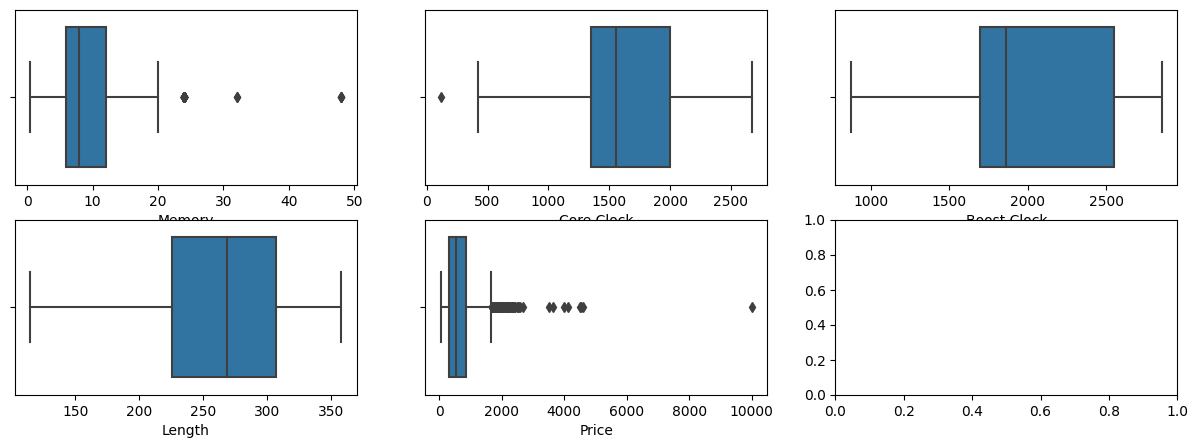

In [123]:
# now let's do some statistical analysis to see if there are any outliers (using subplots)
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
for i, col in enumerate(df.drop(columns=['Chipset_Manufacturer']).columns):
    sns.boxplot(data=df, x=col, ax=axs[i//3, i%3])
    

931 rows remaining after removing outliers


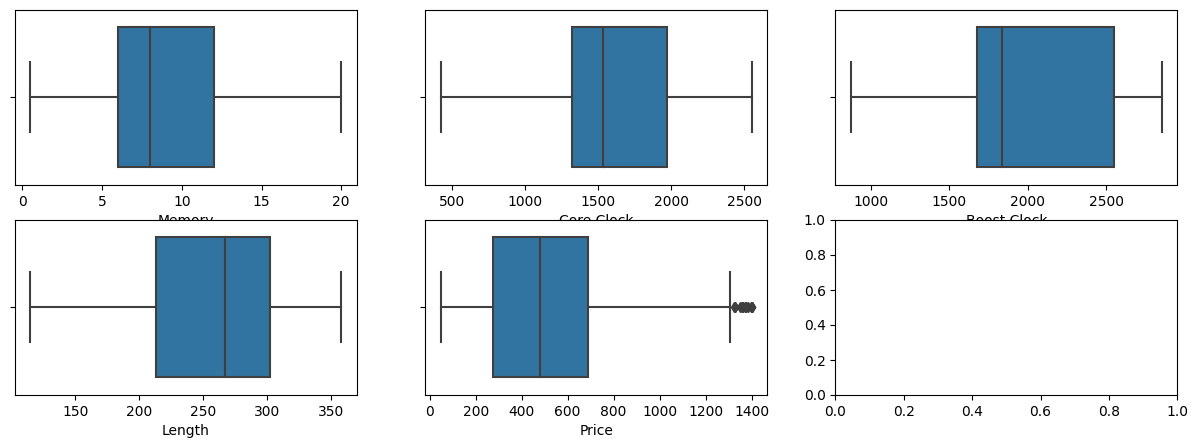

In [124]:
# clearly we have a number of outliers, let's remove them
for col in df.drop(columns=['Chipset_Manufacturer']).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]

# print how many rows remain after removing outliers
print(f'{len(df)} rows remaining after removing outliers')

# let's plot the boxplots again to see if the outliers have been removed
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
for i, col in enumerate(df.drop(columns=['Chipset_Manufacturer']).columns):
    sns.boxplot(data=df, x=col, ax=axs[i//3, i%3])

In [125]:
# Now, let's use PCA to see if we can reduce the dimensionality of our data before clustering, first things we need to do is scale the data
features        = df[feature_cols]
features_scaled = StandardScaler().fit_transform(features)

# next we can fit the PCA model
pca = PCA()
pca_fitted = pca.fit_transform(df[feature_cols])

# and let's create a dataframe from the new PCA features
pca_df = pd.DataFrame(data=pca_fitted, columns=[f'PCA-{i+1}' for i in range(pca_fitted.shape[1])])
pca_df['Chipset_Manufacturer'] = df['Chipset_Manufacturer']
pca_df

,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,Chipset_Manufacturer
0,399.884443,-136.548931,-61.565029,-6.179328,5.282211,nvidia
1,-561.332588,-91.347502,-78.520155,12.755366,1.080853,nvidia
2,-486.342041,-335.472988,-155.904997,23.105455,-1.291250,nvidia
3,-234.984966,25.333863,-612.246278,-7.428244,2.198497,NaN
4,-980.659226,93.551300,136.930588,39.059079,3.854899,NaN
...,...,...,...,...,...,...
926,957.607048,-24.558534,-68.495059,-75.133558,-2.370014,nvidia
927,1172.780485,-87.786103,-76.362617,-38.636865,-1.383846,amd
928,509.280229,-295.662631,-7.444019,-1.880871,-4.322280,amd
929,1205.623185,-169.853810,-68.384685,25.044860,-1.957454,nvidia


In [126]:
# and let's print the explained variance ratio, as well as cumulative explained variance ratio
for i in range(len(pca.explained_variance_ratio_)):
    print(f'PCA-{i+1}: {pca.explained_variance_ratio_[i]*100:>7.4f}% (cumulative: {np.sum(pca.explained_variance_ratio_[:i+1])*100:>8.4f}%)')

PCA-1: 81.1347% (cumulative:  81.1347%)
PCA-2: 14.3056% (cumulative:  95.4402%)
PCA-3:  4.3171% (cumulative:  99.7574%)
PCA-4:  0.2415% (cumulative:  99.9989%)
PCA-5:  0.0011% (cumulative: 100.0000%)


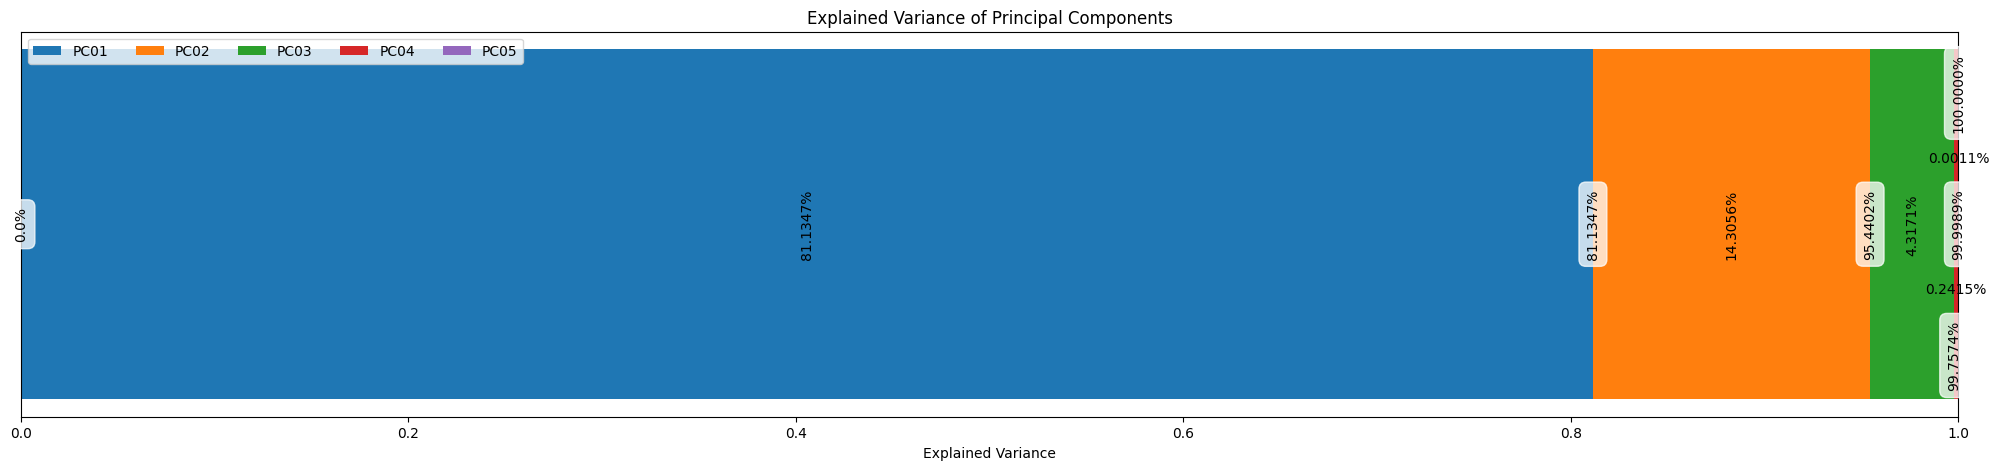

In [127]:
# Let's visualize the explained variance of each principal component to determine if any can be removed
plt.figure(figsize=(25, 5))
for i in range(pca_fitted.shape[1]): # create stacked bar plot for all principal components
    plt.barh(['PC'], pca.explained_variance_ratio_[i], label=f'PC{i+1:02d}', left=np.sum(pca.explained_variance_ratio_[:i]))
plt.legend(ncol=5, loc='upper left')
plt.xlabel('Explained Variance')
plt.xlim(0, 1)
plt.yticks([])
plt.title('Explained Variance of Principal Components')

# add values centered on each bor, and cumulative values at the borders
plt.text(0, 0, '0.0%', ha='center', va='center', rotation=90, bbox=dict(facecolor='white', edgecolor='white', alpha=0.75, boxstyle='round,pad=0.5')) # first cumulative value at zero
for i in range(pca_fitted.shape[1]):

    # vlaues in middle of bars
    if i == 3:
        y = -0.15
        rot = 0
    elif i == 4:
        y = 0.15
        rot = 0
    else:
        y = 0
        rot = 90
    plt.text(np.sum(pca.explained_variance_ratio_[:i+1]) - pca.explained_variance_ratio_[i] / 2, y, f'{pca.explained_variance_ratio_[i]*100:.4f}%', va='center', ha='center', rotation=rot)

    # values at the borders, the last few values are shifted to avoid overlapping the text (what the y value equation is for)
    if i == 2:
        y = -0.3
    elif i == 4:
        y = 0.3
    else:
        y = 0
    plt.text(np.sum(pca.explained_variance_ratio_[:i+1]), y, f'{np.sum(pca.explained_variance_ratio_[:i+1])*100:.4f}%', va='center', ha='center', rotation=90, bbox=dict(facecolor='white', edgecolor='white', alpha=0.75, boxstyle='round,pad=0.5'))

# Store the plot as an object
variance_plot = plt.gcf()

In [128]:
# clearly from  the graph above we can see that there was a lot of duplicate information in the original feature set, and we can still get a 95% explained variance with only the first 2 principal components
# let's create out final dataframe with only these columns
final_df = pca_df[['PCA-1', 'PCA-2', 'Chipset_Manufacturer']]
final_df

,PCA-1,PCA-2,Chipset_Manufacturer
0,399.884443,-136.548931,nvidia
1,-561.332588,-91.347502,nvidia
2,-486.342041,-335.472988,nvidia
3,-234.984966,25.333863,NaN
4,-980.659226,93.551300,NaN
...,...,...,...
926,957.607048,-24.558534,nvidia
927,1172.780485,-87.786103,amd
928,509.280229,-295.662631,amd
929,1205.623185,-169.853810,nvidia


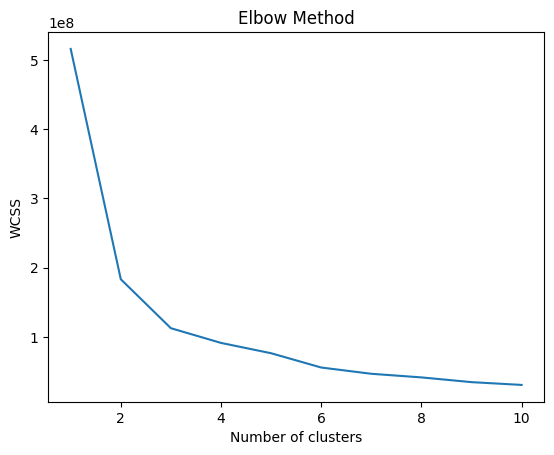

In [129]:
# extract the features to use for clustering
features = final_df.loc[:, ['PCA-1', 'PCA-2']]

# for determining the best number of clusters for out data, we can use the elbow method
wcss = [] #  within-cluster sum of squares
for i in range(1,11):
    model = KMeans(n_clusters = i)
    y_kmeans = model.fit_predict(features)
    wcss.append(model.inertia_)  # adding accuracy to our model

# plot the elbow method
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [130]:
# Based on the elbow method, 3 clusters seems like it will be the best
kmeans = KMeans(n_clusters=3)
predicts = kmeans.fit_predict(features)
final_df = pd.concat([final_df, pd.Series(predicts, name='Cluster')], axis=1)
final_df

,PCA-1,PCA-2,Chipset_Manufacturer,Cluster
0,399.884443,-136.548931,nvidia,2
1,-561.332588,-91.347502,nvidia,1
2,-486.342041,-335.472988,nvidia,1
3,-234.984966,25.333863,NaN,2
4,-980.659226,93.551300,NaN,1
...,...,...,...,...
926,957.607048,-24.558534,nvidia,0
927,1172.780485,-87.786103,amd,0
928,509.280229,-295.662631,amd,2
929,1205.623185,-169.853810,nvidia,0


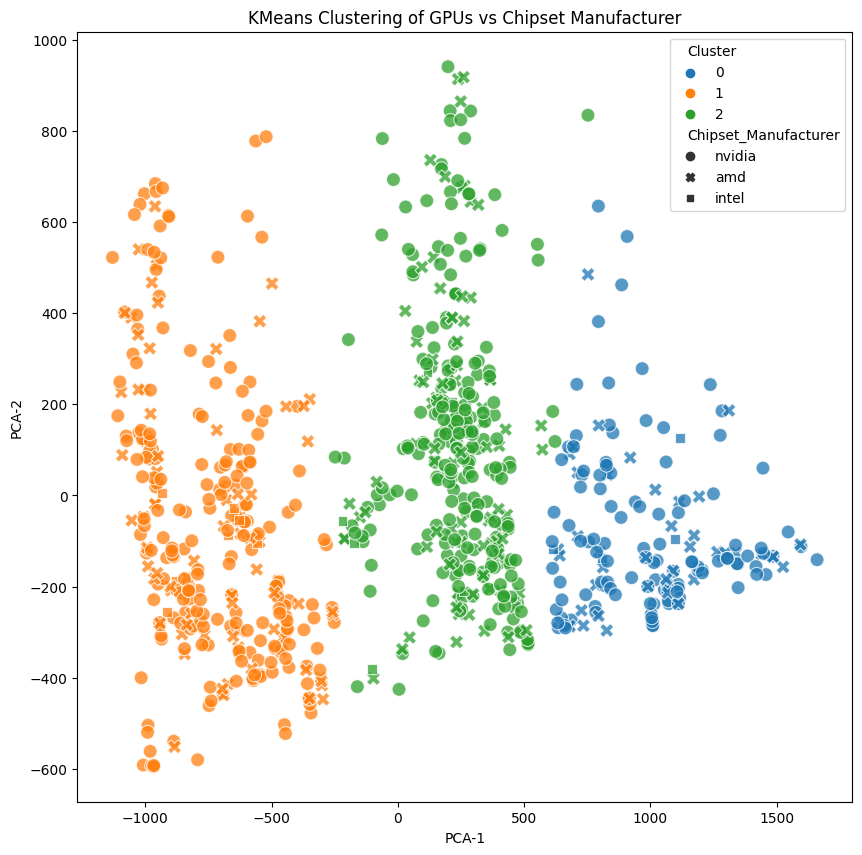

In [131]:
# let's visualize the clusters
plt.figure(figsize=(10, 10))
sns.scatterplot(data=final_df, x='PCA-1', y='PCA-2', hue='Cluster', style='Chipset_Manufacturer', palette='tab10', s=100, alpha=0.75)
plt.title('KMeans Clustering of GPUs vs Chipset Manufacturer')
plt.show()